In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, simps
from mpl_toolkits.mplot3d import axes3d
# import pymsteams
from time import time, localtime, strftime
from datetime import datetime
import os
import sys
plt.style.use('C:\Simulation\Quick Calculations\signature.mplstyle')
# from scipy.interpolate import RegularGridInterpolator as rgi, interp1d
# plt.rcParams['figure.figsize'] = [8, 4]
# plt.rcParams.update({'font.size' : 18})

## workstation path
# path = r'/home/teamgem/Heriot-Watt University Team Dropbox/RES_EPS_Quantum_Photonics_Lab/Experiments/Current Experiments/Visible Quantum Memory/GEM and Stark shift/20240819_GEM_MBE_sims/'
## laptop path
path = r'C:\Users\fgbse\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\Visible Quantum Memory\GEM and Stark shift\20240906_GEM_MBE_sims'
## home path
# path = r'C:\Users\Finley Giles-Book\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\Visible Quantum Memory\GEM and Stark shift\20240815_GEM_MBE_sims'

In [19]:
def lorentz(x,delta,lw,grad,stark,length):
    line_shape = 1/((np.pi * (lw + grad*length/2*stark)*(1 + ((delta + grad*stark*x)/(lw + grad*length/2*stark))**2)))
    return line_shape

def rect_abs_prof(x,delta,lw,OD,grad,stark,length):
    if np.size(x) == 1:
        line_shape =  np.where(abs(delta - grad*stark*x) <= (lw), OD/length, 0)
        return line_shape
    else: 
        line_shape = np.zeros_like(delta)
        for xi in x:
            single_line_shape = np.where(abs(delta - grad*stark*xi) <= (lw), OD/length, 0)
            line_shape += single_line_shape
        return line_shape

def gauss_abs_prof(x,delta,lw,OD,grad,stark,length):
    if np.size(x) == 1:
        # line_shape = OD/((lw + grad*length/2*stark)*np.sqrt(2*np.pi))/length * np.exp(-1/2 * (delta + grad*stark*(x - length/2))**2/(lw)**2)
        line_shape = np.exp(-OD)/length * np.exp(-1/2 * (delta - grad*stark*(x - length/2))**2/(lw)**2)
        return line_shape
    else: 
        line_shape = np.zeros_like(delta)
        for xi in x:
            # single_line_shape = OD/((lw + grad*length/2*stark)*np.sqrt(2*np.pi))/length * np.exp(-1/2 * (delta + grad*stark*(xi - length/2))**2/(lw)**2)
            single_line_shape = np.exp(-OD)/length * np.exp(-1/2 * (delta - grad*stark*(xi - length/2))**2/(lw)**2)
            line_shape += single_line_shape
        return line_shape
    
def lorentz_abs_prof(x,delta,lw,OD,grad,stark,length):
    if np.size(x) == 1:
        line_shape = 1/((np.pi * (lw + grad*length/2*stark)*(1 + ((delta + grad*stark*x)/(lw + grad*length/2*stark))**2)))
        return line_shape
    else: 
        line_shape = np.zeros_like(delta)
        for xi in x:
            single_line_shape = 1/((np.pi * (lw + grad*length/2*stark)*(1 + ((delta + grad*stark*xi)/(lw + grad*length/2*stark))**2)))
            line_shape += single_line_shape
        return line_shape

def grad_switch(t,t_switch):
    if t > t_switch:
        return 1
    else:
        return -1
    
def gauss(t,t_peak,amp,sigma):    
    line_shape = amp*np.exp(-(t - t_peak)**2 / (2 * sigma**2))
    return line_shape

def MBE_pol_z0(t, alpha, t0, A, sigma, delta, x, grad, stark, t_switch, g, gamma, w):

    E = gauss(t,t0,A,sigma)

    dalpha_dt = -(gamma/2)*alpha - (1j) * (delta + grad * stark * grad_switch(t_switch,t) * x)*alpha - (1j) * g * w * E

    return dalpha_dt

def interpolate_E_t(E,t_arr,tn):

    interp = np.interp(tn,t_arr,E)
    return interp

def interpolate_E_z(E,x_arr,xn):

    interp = np.interp(xn,x_arr,E)
    return interp

def MBE_pol_z(t, alpha, E, t_arr, delta, x_n, lw, OD, grad, stark, t_switch, g, gamma, w, length):
    
    Ez = interpolate_E_t(E,t_arr,t)

    # dalpha_dt = -(gamma/2)*alpha - (1j) * (delta + grad * stark * grad_switch(t,t_switch) * (x_n - length/2))*alpha - (1j) * g * w * Ez
    dalpha_dt = -(gamma/2)*alpha - (1j) * (gauss_abs_prof(x_n,delta,lw,OD,grad,stark,length) * grad * stark * grad_switch(t,t_switch) * (x_n - length/2))*alpha - (1j) * g * w * Ez
    # dalpha_dt = -(gamma/2)*alpha - (1j) * (grad * stark * grad_switch(t,t_switch) * (x_n - length/2))*alpha - (1j) * g * w * Ez
    return dalpha_dt

def MBE_field(x, E, delta, delta_range, t0, t1, Nd, Nt, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, length):

    # Calculate the optical field over dz
    # Since the the function calculates the spatial derivative of 
    # E and the eqn does not include any terms with E then then initial value of E is not needed
    # rhs_int is the initial value

    # E1 = E0-E[:,0]*np.log(-OD)
    # E1 = E0-E[:,0]
    # E1 = E0
    # E1 = E[:,0]
    # E1 = E0*np.exp(-OD*((length/2 + x)/length))
    E1 = E0*np.exp(-OD*(x/length))
    
    # sol_alpha_z = solve_ivp(MBE_pol_z,
    #                         (t0, t1),
    #                         alpha0,
    #                         args=(E1, t_arr, delta, x, lw, OD, grad, stark, t_switch, g, gamma, w0, length),
    #                         t_eval=t_arr,
    #                         dense_output=True,
    #                         vectorized=True,
    #                         method='RK45')
    
    # alpha = sol_alpha_z.y.T

    alpha_temp = np.zeros((Nt, Nd), dtype=np.complex128)

    for i in range(Nd):
        sol_alpha_z = solve_ivp(MBE_pol_z,
                                (t0, t1),
                                alpha0,
                                args=(E1, t_arr, delta[i], x, lw, OD, grad, stark, t_switch, g, gamma, w0, length),
                                t_eval=t_arr,
                                dense_output=True,
                                vectorized=False,
                                method='RK45')
        
        plt.imshow(abs(alpha_temp))
            
        alpha_temp[:,i] = np.sum(sol_alpha_z.y.T,axis=1)
    # dE_dx = -simps(gauss_abs_prof(x,delta,lw,OD,grad,stark,length)*alpha,axis=1)
    dE_dx = -simps(gauss_abs_prof(x,delta,lw,OD,grad,stark,length)*alpha_temp,axis=1)

    print('z = ', round(x,2), ', delta = ', round((grad*stark*(x - length/2)),2))

    return dE_dx

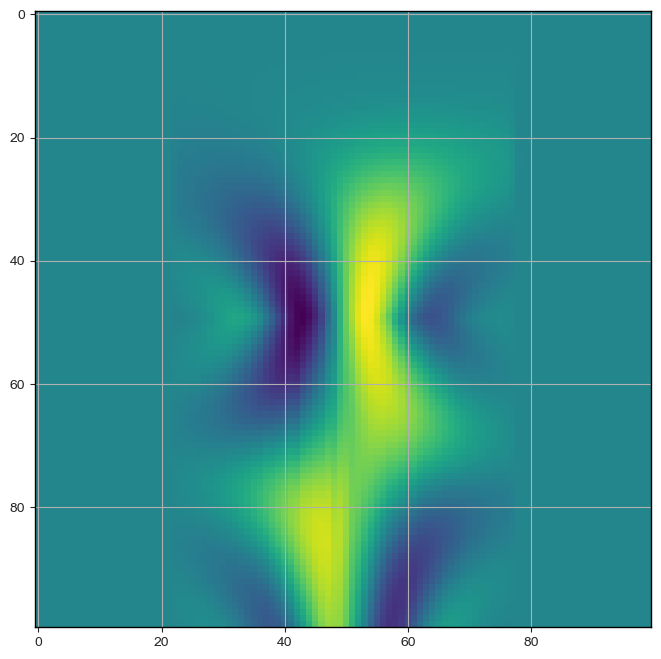

In [53]:
A = np.zeros((Nx,Nd,Nt),dtype=np.complex128)

for i in range(Nx):
    A[i,:,:] = gauss_abs_prof(x_arr[i],delta,lw,OD,grad,stark,L)*alpha[i,:,:]

B = np.sum(A,0)

plt.imshow(np.real(B))

In [ ]:
plt.plot(E0*np.exp(-OD*(x_arr[0]/L)))
plt.plot(E0*np.exp(-OD*(x_arr[-1]/L)))

In [20]:
# Parameters - converted assuming that k0/2e0 = lambda (wavelength) = 1

gamma = 0.31#0.01#0.31      # Polarization decay rate
g = 406#2000#406                                 # Transition coupling strength
t_input = 2.5                                 # Gaussian pulse peak time
sigma = 1/np.sqrt(2*np.log(2))        # Gaussian pulse sigma (time domain)
OD = 1                             # Optical depth used in Lorentzian
grad = 1E6#7.37e-11                         # Electric field gradient
stark = 6.74e-10                        # Stark coefficient
lw = 0.1                                      # Zero field absorption linewidth
t_switch = 5                           # Gradient direction switch time
A = 3.5e3#-3                              # Electric field magnitude
L = 16475                               # Optical path length
t_total = 10
w0 = -1                                 # Atomic excitation field

# Discretisation

Nx = 100          # Spatial grid  
# x_arr = np.linspace(-L/2, L/2, Nx)
x_arr = np.linspace(0, L, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 200            # Time grid
t_arr = np.linspace(0, t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 100
delta_range = 20  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

# Initialisation

alpha0 = np.zeros(Nx, dtype=np.complex128)
E0 = np.complex128(gauss(t_arr,t_input,A,sigma))

alpha = np.zeros((Nd, Nt, Nx), dtype=np.complex128)
E = np.zeros((Nt, Nx), dtype=np.complex128)
P = np.zeros((Nt, Nx), dtype=np.complex128)

# E[0,:] = E0

t_E_start = time()

sol = solve_ivp(MBE_field,
                (x0, x1),
                E0,
                args=(delta, delta_range, t0, t1, Nd, Nt, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L),
                t_eval=x_arr,
                dense_output=True,
                vectorized=True,
                method='RK45')
    
E = sol.y

with open(os.path.join(path,r'E.npy'),'wb') as f:
    np.save(f, E)

t_E = time() - t_E_start

t_alpha_start = time()

# alpha
for i in range(Nx):
    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            # args=(E[:,i], t_arr, delta_range, x_arr[i], grad, stark, t_switch, g, gamma, w0, L),
                            args=(E[:,i], t_arr, delta, x_arr[i], lw, OD, grad, stark, t_switch, g, gamma, w0, L),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK45')
    print('z = ', round(x_arr[i],2))
    
    alpha[:,:,i] = sol_alpha_z.y

with open(os.path.join(path,r'alpha.npy'),'wb') as f:
    np.save(f, alpha)

t_alpha = time() - t_alpha_start

t_P_start = time()

P = 1j * simps(gauss_abs_prof(x_arr,delta,lw,OD,grad,stark,L)*alpha.T,axis=2)

# for i in range(Nx):
#     for j in range(Nt):
#         P[j,i] = 1j*simps(gauss_abs_prof(x_arr[i],delta,lw,OD,grad,stark,L)*alpha[:,j,i])

with open(os.path.join(path + r'P.npy'),'wb') as f:
    np.save(f, P)

t_P = time() - t_P_start

E = np.rot90(E)
# alpha = np.rot90(alpha)
P = np.flipud(P)

z =  0.0 , delta =  -5.55
z =  0.0 , delta =  -5.55
z =  0.0 , delta =  -5.55
z =  0.0 , delta =  -5.55
z =  0.0 , delta =  -5.55


KeyboardInterrupt: 

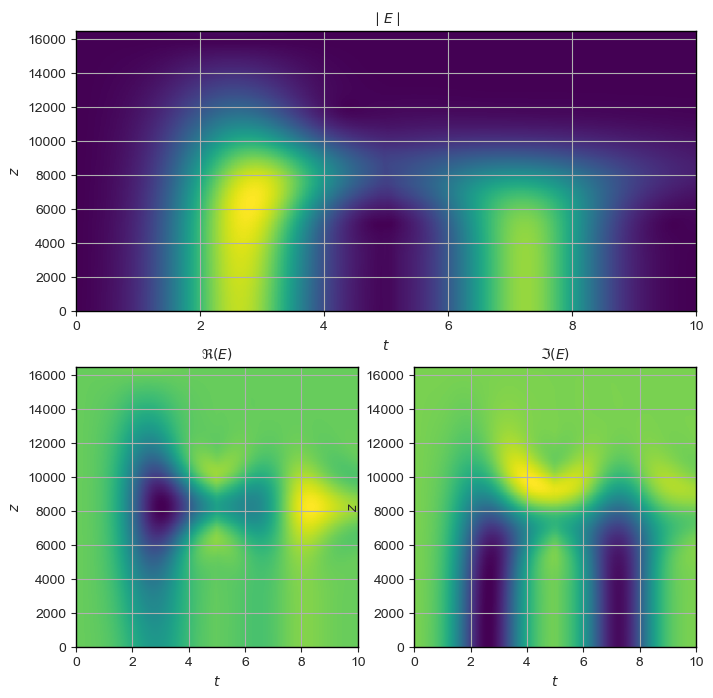

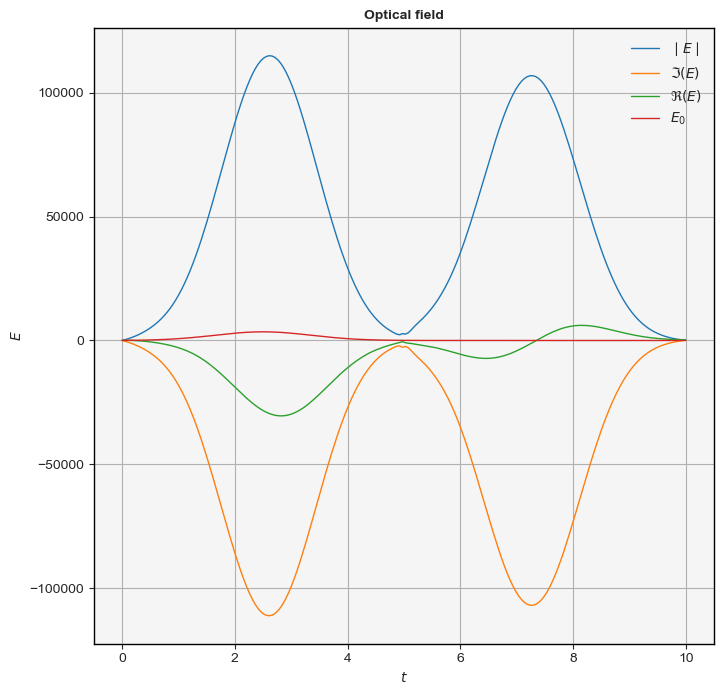

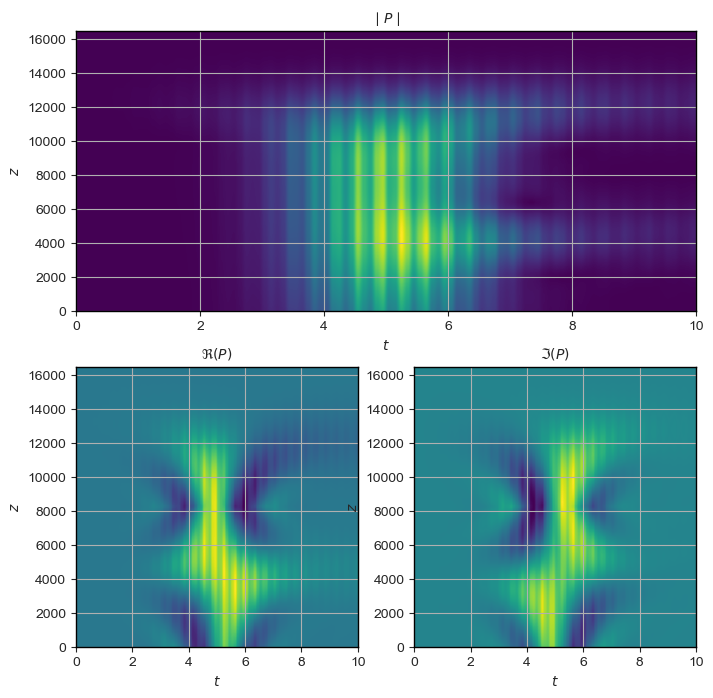

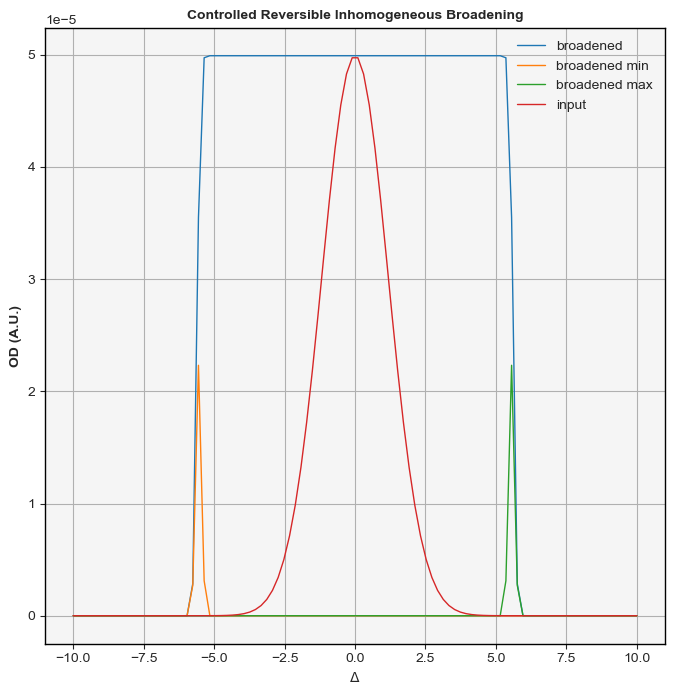

In [103]:
plt.subplot(2,1,1)
plt.imshow(abs(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(E),aspect='auto',origin='lower')
plt.title(r'$\mid E \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(E),aspect='auto',origin='lower')
plt.title(r'$\Re(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(E),aspect='auto',origin='lower')
plt.title(r'$\Im(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'optical field'))

plt.figure()
# plt.plot(t_arr,abs(E[-1,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,abs(E[0,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,np.imag(E[0,:]),label=r'$\Im(E)$')
plt.plot(t_arr,np.real(E[0,:]),label=r'$\Re(E)$')
plt.plot(t_arr,abs(E0),label=r'$E_0$')
plt.title(r'Optical field')
plt.xlabel(r'$t$')
plt.ylabel(r'$E$')
plt.legend()
plt.savefig(os.path.join(path,r'optical field 2D'))

# plt.figure()
# # alpha_sum = np.rot90(np.sum(alpha, axis=2))
# alpha_sum = np.rot90(np.sum(alpha, axis=2))
# plt.subplot(2,1,1)
# plt.imshow(abs(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(abs(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\mid \alpha \mid$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,3)
# plt.imshow(np.real(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.real(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Re(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,4)
# plt.imshow(np.imag(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.imag(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Im(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.savefig(os.path.join(path,r'atomic polarization'))

plt.figure()
plt.subplot(2,1,1)
plt.imshow(abs(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(P),aspect='auto',origin='lower')
plt.title(r'$\mid P \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(P),aspect='auto',origin='lower')
plt.title(r'$\Re(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(P),aspect='auto',origin='lower')
plt.title(r'$\Im(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'polarization density'))

plt.figure()
# plt.plot(delta,gauss_abs_prof(x_arr,delta,lw,OD,0,stark,L),label='unbroadened')
plt.plot(delta,gauss_abs_prof(x_arr,delta,lw,OD,grad,stark,L),label='broadened')
plt.plot(delta,gauss_abs_prof(x_arr[0],delta,lw,OD,grad,stark,L),label='broadened min')
plt.plot(delta,gauss_abs_prof(x_arr[-1],delta,lw,OD,grad,stark,L),label='broadened max')
plt.plot(delta,gauss(delta,0,max(gauss_abs_prof(x_arr,delta,lw,OD,grad,stark,L)),1/sigma),label='input')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()
plt.savefig(os.path.join(path,r'controlled reversible inhomogeneous broadening'))

plt.show()

with open(os.path.join(path,'params.txt'), 'w') as f:
    f.writelines('MBE simulations params\n')
    f.writelines(f'{strftime("%d/%m/%Y %H:%M:%S")}\n')
    f.writelines('\n')
    f.writelines(f'E calculation time = {t_E}\n')
    f.writelines(f'alpha calculation time = {t_alpha}\n')
    f.writelines(f'P calculation time = {t_P}\n')
    f.writelines('\n')
    f.writelines(f'gamma = {gamma}\n')
    f.writelines(f'g = {g}\n')
    f.writelines(f't_input = {t_input}\n')
    f.writelines(f'sigma = {sigma}\n')
    f.writelines(f'OD = {OD}\n')
    f.writelines(f'grad = {grad}\n')
    f.writelines(f'stark = {stark}\n')
    f.writelines(f'lw = {lw}\n')
    f.writelines(f't_switch = {t_switch}\n')
    f.writelines(f'A = {A}\n')
    f.writelines(f'L = {L}\n')
    f.writelines(f't_total = {t_total}\n')
    f.writelines(f'w0 = {w0}\n')
    f.writelines(f'Nx = {Nx}\n')
    f.writelines(f'Nt = {Nt}\n')
    f.writelines(f'Nd = {Nd}\n')
    f.writelines(f'delta_range = {delta_range}\n')

# myTeamsMessage = pymsteams.connectorcard("https://heriotwatt.webhook.office.com/webhookb2/36c66bd3-00f2-4593-9e53-9c5f95266f6b@6c425ff2-6865-42df-a4db-8e6af634813d/IncomingWebhook/bfb3c210c4e246a0b921828743844f4c/7c7eb11d-34da-4e09-abca-fcaefc441bad")
# myTeamsMessage.text("Neutroooooooooon, your simulations are done NERD!")
# myTeamsMessage.send()

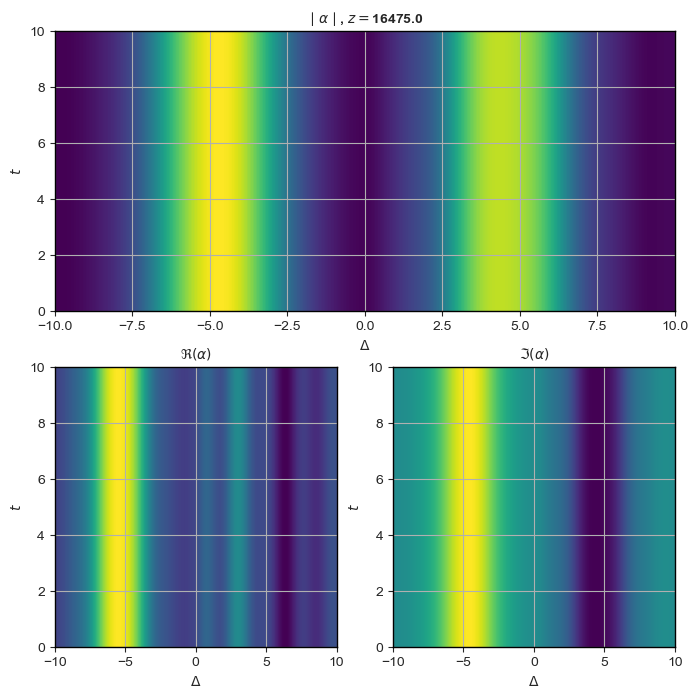

In [88]:
plt.figure()
i = -1
plt.subplot(2,1,1)
plt.imshow(abs(alpha[:,:,i]),extent=[d0, d1, t0, t1],aspect='auto',origin='lower')
# plt.imshow(abs(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\mid \alpha \mid$, $z = $' + f'{round(x_arr[i],2)}')
plt.ylabel(r'$t$')
plt.xlabel(r'$\Delta$')
plt.subplot(2,2,3)
plt.imshow(np.real(alpha[:,:,i]),extent=[d0, d1, t0, t1],aspect='auto',origin='lower')
# plt.imshow(np.real(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\Re(\alpha)$')
plt.ylabel(r'$t$')
plt.xlabel(r'$\Delta$')
plt.subplot(2,2,4)
plt.imshow(np.imag(alpha[:,:,i]),extent=[d0, d1, t0, t1],aspect='auto',origin='lower')
# plt.imshow(np.imag(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\Im(\alpha)$')
plt.ylabel(r'$t$')
plt.xlabel(r'$\Delta$')
plt.savefig(os.path.join(path,f'atomic polarization z_i'))

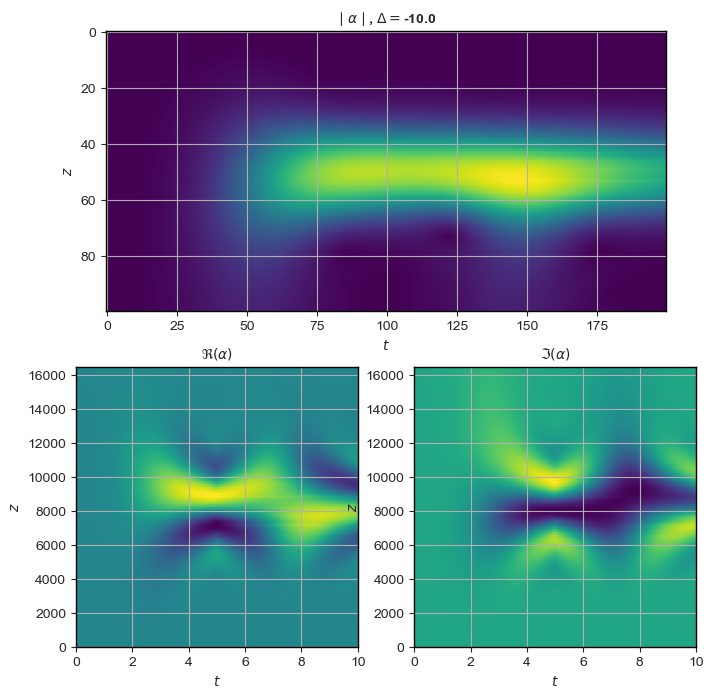

In [94]:
plt.figure()
i = 0
plt.subplot(2,1,1)
plt.imshow(abs(alpha[i,:,:].T))#,extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\mid \alpha \mid$, $\Delta = $' + f'{round(delta[i],2)}')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(alpha[i,:,:].T),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\Re(\alpha)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(alpha[i,:,:].T),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\Im(\alpha)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,f'atomic polarization delta_i'))

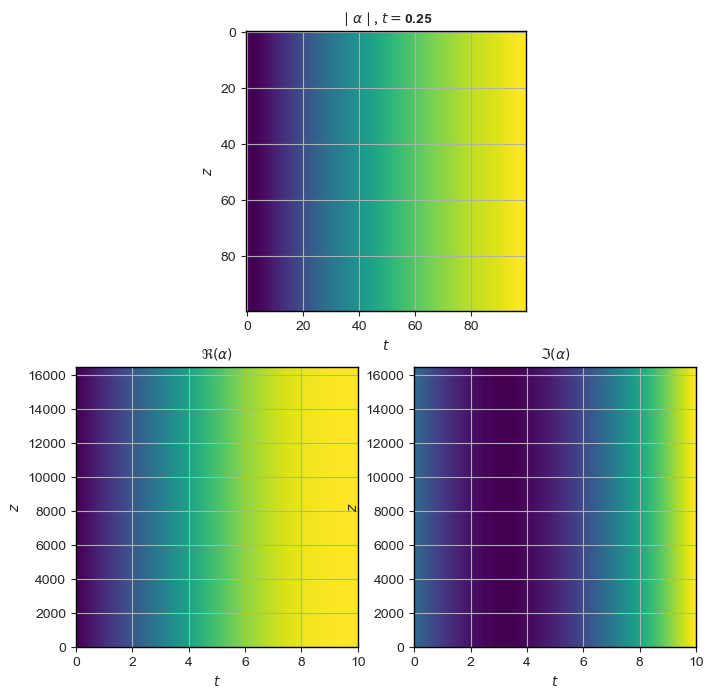

In [101]:
plt.figure()
i = 5
plt.subplot(2,1,1)
plt.imshow(abs(alpha[:,i,:]))#,extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\mid \alpha \mid$, $t = $' + f'{round(t_arr[i],2)}')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(alpha[:,i,:]),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\Re(\alpha)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(alpha[:,i,:]),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(alpha_sum),aspect='auto',origin='lower')
plt.title(r'$\Im(\alpha)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,f'atomic polarization t_i'))

In [120]:
# Parameters - converted assuming that k0/2e0 = lambda (wavelength) = 1

gamma = 3.1E5                            # Polarization decay rate
g = 246.45                                 # Transition coupling strength
t_input = 2E-6                                 # Gaussian pulse peak time
sigma = 0.5E-6                            # Gaussian pulse sigma
OD = 1                                  # Optical depth used in Lorentzian
grad = 5E5                         # Electric field gradient
stark = 1116                        # Stark coefficient
lw = 0.25E6                                  # Zero field absorption linewidth
t_switch = 5E-6                            # Gradient direction switch time
A = 577                              # Electric field magnitude
L = 1E-2                               # Optical path length
t_total = 10E-6
w0 = -1                                 # Atomic excitation field

# Discretisation

Nx = 200          # Spatial grid  
x_arr = np.linspace(-L/2, L/2, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 200            # Time grid
t_arr = np.linspace(0,t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 200
delta_range = 20E6  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

# Initialisation

alpha0 = np.zeros(Nd, dtype=np.complex128)
E0 = np.complex128(gauss(t_arr,t_input,A,sigma))

alpha = np.zeros((Nd, Nt, Nx), dtype=np.complex128)
E = np.zeros((Nt, Nx), dtype=np.complex128)
P = np.zeros((Nt, Nx), dtype=np.complex128)

# E[0,:] = E0

t_E_start = time()

sol = solve_ivp(MBE_field,
                (x0, x1),
                E0,
                args=(delta, t0, t1, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L),
                t_eval=x_arr,
                dense_output=True,
                vectorized=True,
                method='RK45')
    
E = sol.y

with open(os.path.join(path,r'E.npy'),'wb') as f:
    np.save(f, E)

t_E = time() - t_E_start

t_alpha_start = time()

# alpha
for i in range(Nx):
    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            args=(E[:,i], t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            # args=(E0, t_arr, delta, x_arr[i], grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK45')
    print(i)
    
    alpha[:,:,i] = sol_alpha_z.y

with open(os.path.join(path,r'alpha.npy'),'wb') as f:
    np.save(f, alpha)

t_alpha = time() - t_alpha_start

t_P_start = time()

# for i in range(Nx):
#     P[:,i] = simps(rect_abs_prof_1(x_arr[i],delta,lw,OD,grad,stark,L)*alpha,axis=2)
# P = np.sum(P,axis=2)
P = 1j * simps(gauss_abs_prof(x_arr,delta,lw,OD,grad,stark,L)*alpha,axis=2)

with open(os.path.join(path + r'P.npy'),'wb') as f:
    np.save(f, P)

t_P = time() - t_P_start

E = np.rot90(E)
# P = np.rot90(P)

-0.005
145.43346785959213
-0.003
-0.002
0.003
0.0038888888888888888
0.005
0.005
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


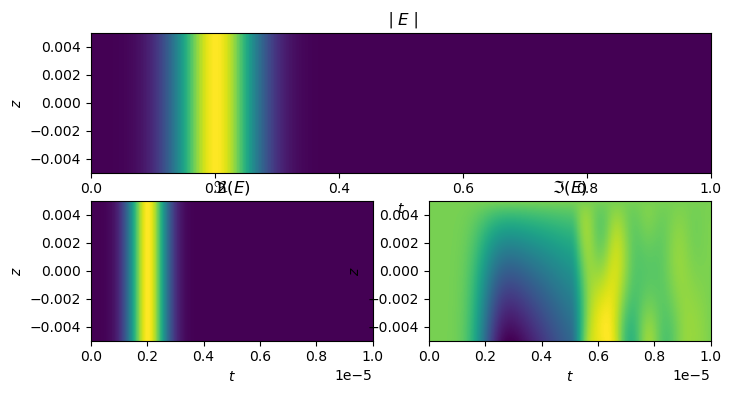

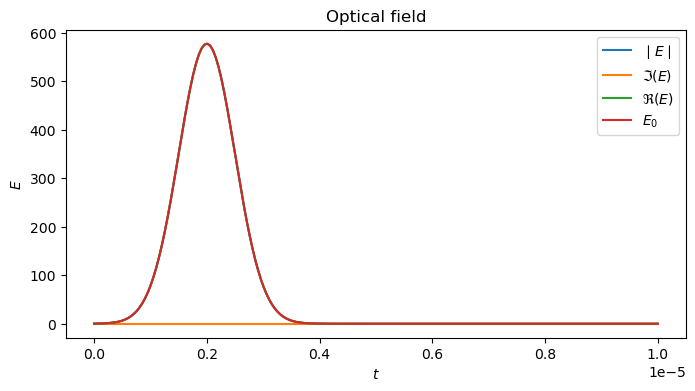

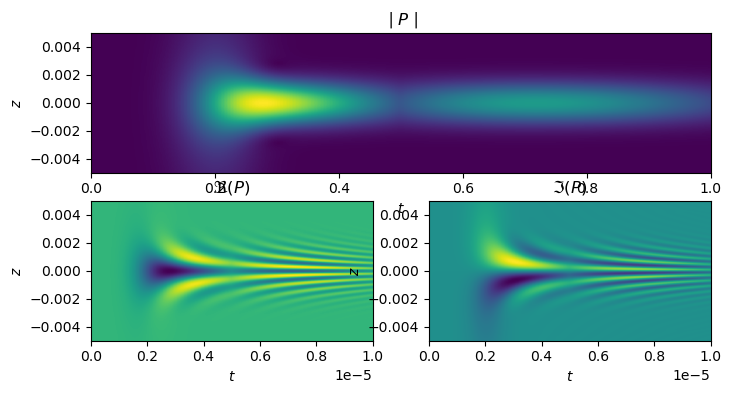

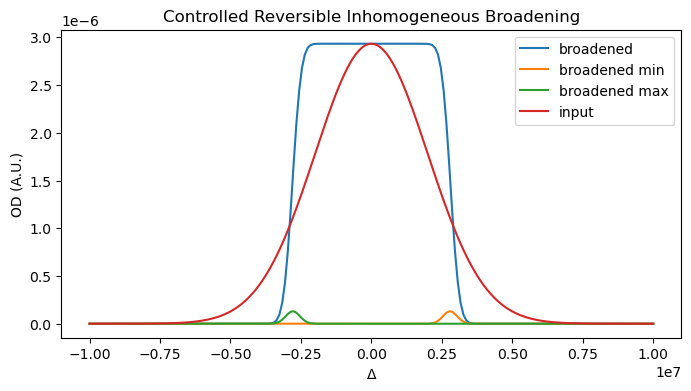

In [121]:
plt.subplot(2,1,1)
plt.imshow(abs(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(E),aspect='auto',origin='lower')
plt.title(r'$\mid E \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(E),aspect='auto',origin='lower')
plt.title(r'$\Re(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(E),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(E),aspect='auto',origin='lower')
plt.title(r'$\Im(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'optical field'))

plt.figure()
# plt.plot(t_arr,abs(E[-1,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,abs(E[0,:]),label=r'$\mid E \mid$')
plt.plot(t_arr,np.imag(E[0,:]),label=r'$\Im(E)$')
plt.plot(t_arr,np.real(E[0,:]),label=r'$\Re(E)$')
plt.plot(t_arr,abs(E0),label=r'$E_0$')
plt.title(r'Optical field')
plt.xlabel(r'$t$')
plt.ylabel(r'$E$')
plt.legend()
plt.savefig(os.path.join(path,r'optical field 2D'))

# plt.figure()
# # alpha_sum = np.rot90(np.sum(alpha, axis=2))
# alpha_sum = np.rot90(np.sum(alpha, axis=2))
# plt.subplot(2,1,1)
# plt.imshow(abs(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(abs(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\mid \alpha \mid$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,3)
# plt.imshow(np.real(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.real(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Re(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.subplot(2,2,4)
# plt.imshow(np.imag(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# # plt.imshow(np.imag(alpha_sum),aspect='auto',origin='lower')
# plt.title(r'$\Im(\alpha)$')
# plt.xlabel(r'$t$')
# plt.ylabel(r'$z$')
# plt.savefig(os.path.join(path,r'atomic polarization'))

plt.figure()
plt.subplot(2,1,1)
plt.imshow(abs(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(abs(P),aspect='auto',origin='lower')
plt.title(r'$\mid P \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.real(P),aspect='auto',origin='lower')
plt.title(r'$\Re(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(P),extent=[t0, t1, x0, x1],aspect='auto',origin='lower')
# plt.imshow(np.imag(P),aspect='auto',origin='lower')
plt.title(r'$\Im(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'polarization density'))

plt.figure()
# plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,0,L),label='unbroadened')
plt.plot(delta,gauss_abs_prof(x_arr,delta,lw,OD,grad,stark,L),label='broadened')
plt.plot(delta,gauss_abs_prof(x_arr[0],delta,lw,OD,grad,stark,L),label='broadened min')
plt.plot(delta,gauss_abs_prof(x_arr[-1],delta,lw,OD,grad,stark,L),label='broadened max')
plt.plot(delta,gauss(delta,0,max(gauss_abs_prof(x_arr,delta,lw,OD,grad,stark,L)),1/sigma),label='input')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()
plt.savefig(os.path.join(path,r'controlled reversible inhomogeneous broadening'))

plt.show()

with open(os.path.join(path,'params.txt'), 'w') as f:
    f.writelines('MBE simulations params\n')
    f.writelines(f'{strftime("%d/%m/%Y %H:%M:%S")}\n')
    f.writelines('\n')
    f.writelines(f'E calculation time = {t_E}\n')
    f.writelines(f'alpha calculation time = {t_alpha}\n')
    f.writelines(f'P calculation time = {t_P}\n')
    f.writelines('\n')
    f.writelines(f'gamma = {gamma}\n')
    f.writelines(f'g = {g}\n')
    f.writelines(f't_input = {t_input}\n')
    f.writelines(f'sigma = {sigma}\n')
    f.writelines(f'OD = {OD}\n')
    f.writelines(f'grad = {grad}\n')
    f.writelines(f'stark = {stark}\n')
    f.writelines(f'lw = {lw}\n')
    f.writelines(f't_switch = {t_switch}\n')
    f.writelines(f'A = {A}\n')
    f.writelines(f'L = {L}\n')
    f.writelines(f't_total = {t_total}\n')
    f.writelines(f'w0 = {w0}\n')
    f.writelines(f'Nx = {Nx}\n')
    f.writelines(f'Nt = {Nt}\n')
    f.writelines(f'Nd = {Nd}\n')
    f.writelines(f'delta_range = {delta_range}\n')

# myTeamsMessage = pymsteams.connectorcard("https://heriotwatt.webhook.office.com/webhookb2/36c66bd3-00f2-4593-9e53-9c5f95266f6b@6c425ff2-6865-42df-a4db-8e6af634813d/IncomingWebhook/bfb3c210c4e246a0b921828743844f4c/7c7eb11d-34da-4e09-abca-fcaefc441bad")
# myTeamsMessage.text("Neutroooooooooon, your simulations are done NERD!")
# myTeamsMessage.send()